In [1]:
import argparse
import os
import sys
import glob
import timeit
import pandas as pd
import pickle

def list_files(directory):
    return glob.glob(os.path.join(directory, "*.jpeg")) + glob.glob(os.path.join(directory, "*.jpg")) + glob.glob(os.path.join(directory, "*.png")) + glob.glob(os.path.join(directory, "*.JPG")) + glob.glob(os.path.join(directory, "*.JPEG"))

def load_from_file(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)
    
# Extend PYTHONPATH
project_root = os.path.abspath('..')
retrievers_path = os.path.abspath('../src/retrievers') 
sys.path.append(project_root)
sys.path.append(retrievers_path)

# Overview

This Jupyter Notebook is divided into two main sections:

- **Computational Part:** In this section, you can initialize the model, encode images, and compute cumulative values and ranks. This part is resource-intensive as it involves downloading the model and encoding all images from the selected dataset. The results are saved to predefined locations with predefined filenames. If a GPU is available (with CUDA support), the code will utilize it to run on the GPU.

- **Plotting Part:** This section uses the results from the Computational Part to generate various plots. In my submitted solution, I included all precomputed cumulative and rank files, so you won't need to recompute them. With the provided code, you can plot cumulative graphs for selected models, generate all combinations of scatter plots for selected models, and create complementary cumulative graphs for selected models.



First thing to do is to select Dataset , Model, Label type and Version of the Model if needed.

In [2]:
DATASET = 'photos' # {'photos', 'marine', 'lsc', 'reset'}
MODEL = 'clip' # {'clip', 'blip2', 'align', 'openclip'}
VERSION = None # Version of 'openclip' {'ViT_SO400M_14_webli', 'ViT_H_14_dfn5b', 'ViT_L_16_webli', 'ViT_B_16_webli', 'ViT_G_14_laion2b', 'ViT_H_14_laion2b'}
LABELS_TYPE = 'short' # {'short', 'long'}

## Computational Part

### Installations
Installing all the libraries for all the models might be unnecessary. Here is simple dahsboard that allows to install only needed libraries.

CLIP

In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

BLIP2

In [ ]:
!pip install salesforce-lavis

ALIGN

In [ ]:
!pip install transformers

OpenCLIP

In [ ]:
!pip install open_clip_torch

### Initilaize Model

In [5]:
IDs_fromat = False if DATASET == 'lsc' or DATASET == 'reset' else True
if MODEL == 'clip':
    from clip_retriever import CLIPRetriever
    retriever = CLIPRetriever(IDs_fromat)
elif MODEL == 'align':
    from align_retriever import ALIGNRetriever
    retriever = ALIGNRetriever(IDs_fromat)
elif MODEL == 'blip2':
    from blip2_retriever import BLIP2Retriever
    retriever = BLIP2Retriever(IDs_fromat) 
elif MODEL == 'openclip':
    if VERSION is None:
        print("Specify openclip version")
        sys.exit(1)
    else:
        from openclip_retriever import OpenCLIPRetriever
        retriever = OpenCLIPRetriever(version=VERSION, IDs_in_integer_format=IDs_fromat)

### Encode Images

Create the image encodings with MODEL for all the images form DATASET. After encoding process the image features are saved to predefined location.

In [6]:
dataset_path = f'datasets/{DATASET}/data'
dataset_path = os.path.join(project_root, dataset_path)
storage_path = f'saves/image_features/{MODEL}-' + ((VERSION + '-') if MODEL == 'openclip' else '') + DATASET + '.pkl'
storage_path = os.path.join(project_root, storage_path)
batch_size = 100

images_paths = list_files(dataset_path)

# Measure the execution time of images encoding
print("Encoding dataset...")
execution_time = timeit.timeit(lambda: retriever.encode_images(images_paths, storage_path, batch_size), number=1)
print(f"Encoding finished, execution time: {execution_time} s")


Encoding dataset...
Encoding started - batch_size=100 - num_of_batches=6
    batch 1. encoded
    batch 2. encoded
    batch 3. encoded
    batch 4. encoded
    batch 5. encoded
    batch 6. encoded
Encoding finished, execution time: 52.29638901700014 s


### Compute Cumulation

In [7]:
image_encodings_path = f'saves/image_features/{MODEL}-' + ((VERSION + '-') if MODEL == 'openclip' else '') + DATASET + '.pkl'
image_encodings_path = os.path.join(project_root, image_encodings_path)
labels_path = f'datasets/{DATASET}/labels/labels.csv'
labels_path = os.path.join(project_root, labels_path)
cumulation_storage_path = f'saves/cumulations/{MODEL}-' + ((VERSION + '-') if MODEL == 'openclip' else '') + DATASET + f'-{LABELS_TYPE}.pkl'
cumulation_storage_path = os.path.join(project_root, cumulation_storage_path)

# Load image_features
retriever.load_encoded_images(image_encodings_path)

# Load and prepare labels
labels = pd.read_csv(labels_path, dtype={"ID": str})
if LABELS_TYPE == 'short':
    labels = labels[['ID','short_label']]
elif LABELS_TYPE == 'long':
    labels = labels[['ID','long_label']]
labels.columns = ['ID', 'label']

# Measure the execution time
print("Starting evaluation")
execution_time = timeit.timeit(lambda: retriever.compute_cumulation(labels, cumulation_storage_path), number=1)
print(f"Evaluation finished, execution time: {execution_time} s")



Image encodings(and Image IDs) loaded...
Starting evaluation
Evaluation finished, execution time: 4.563720784999987 s


### Compute Ranks

In [8]:
image_encodings_path = f'saves/image_features/{MODEL}-' + ((VERSION + '-') if MODEL == 'openclip' else '') + DATASET + '.pkl'
image_encodings_path = os.path.join(project_root, image_encodings_path)
labels_path = f'datasets/{DATASET}/labels/labels.csv'
labels_path = os.path.join(project_root, labels_path)
ranks_storage_path = f'saves/ranks/{MODEL}-' + ((VERSION + '-') if MODEL == 'openclip' else '') + DATASET + f'-{LABELS_TYPE}.pkl'
ranks_storage_path = os.path.join(project_root, ranks_storage_path)

# Load image_features
retriever.load_encoded_images(image_encodings_path)

# Load and prepare labels
labels = pd.read_csv(labels_path, dtype={"ID": str})
if LABELS_TYPE == 'short':
    labels = labels[['ID','short_label']]
elif LABELS_TYPE == 'long':
    labels = labels[['ID','long_label']]
labels.columns = ['ID', 'label']

# Measure the execution time
print("Starting ranks computation")
execution_time = timeit.timeit(lambda: retriever.compute_ranks(labels, ranks_storage_path), number=1)
print(f"Ranks computation finished, execution time: {execution_time} s")

Image encodings(and Image IDs) loaded...
Starting ranks computation
Ranks computation finished, execution time: 5.763335068999822 s


### Plot Cumulative Graph

First cell contains the help functions.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

def load_from_file(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)

def plot_cumulative_graph(cumulations, m, names, title , colors, out_path, line_width):
    # Generate x values (ranks)
    x = np.arange(1, m + 1)
    
    # Plot each set of cumulations
    for cumulation, (name ,color) in zip(cumulations, zip(names,colors)):
        cumulation = cumulation[:m]
        y = np.array(cumulation)
        plt.plot(x, y, linestyle='-', linewidth=line_width, label=name, color=color, alpha=0.8)

    # Set ticks
    stride = m // 10 # 10 ticks
    ticks = [1] + list(range(stride ,m+1, stride))
    plt.xticks(ticks)
    plt.yticks(range(0,101,10))

    # Set grids
    plt.grid(axis='y', linestyle='--', alpha=0.25)
    plt.grid(axis='x', linestyle='--', alpha=0.25)

    # Labeling axes
    # plt.xlabel('Rank')
    # plt.ylabel('Count')

    # Title
    if title is not None:
        plt.title(title)

    # Legend
    plt.legend(fontsize='13')

    # Show and save plot
    if out_path is not None:
        plt.savefig(out_path, dpi=600, bbox_inches='tight', pad_inches=0)
    plt.show()

Plot the cumulative graph for the DATASET and LABELS_TYPE. Note that in the cumulative graph all the models are featured so to plot it we need precomputed cumulations for all the models.

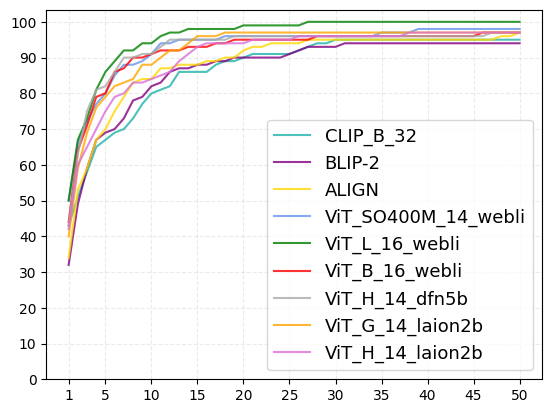

In [10]:
directory = "saves/cumulations/"
directory = os.path.join(project_root, directory)
out_path = None # f"saves/plots/cumulative_graphs/{DATASET}_{LABELS_TYPE}.png"
marine_short_cumulations = ['clip-marine-short.pkl','blip2-marine-short.pkl','align-marine-short.pkl','openclip-ViT_SO400M_14_webli-marine-short.pkl', 'openclip-ViT_H_14_dfn5b-marine-short.pkl', 'openclip-ViT_L_16_webli-marine-short.pkl', 'openclip-ViT_B_16_webli-marine-short.pkl', 'openclip-ViT_G_14_laion2b-marine-short.pkl', 'openclip-ViT_H_14_laion2b-marine-short.pkl']
marine_long_cumulations = ['clip-marine-long.pkl','blip2-marine-long.pkl','align-marine-long.pkl','openclip-ViT_SO400M_14_webli-marine-long.pkl', 'openclip-ViT_H_14_dfn5b-marine-long.pkl', 'openclip-ViT_L_16_webli-marine-long.pkl', 'openclip-ViT_B_16_webli-marine-long.pkl', 'openclip-ViT_G_14_laion2b-marine-long.pkl', 'openclip-ViT_H_14_laion2b-marine-long.pkl']
photos_short_cumulations = ['clip-photos-short.pkl','blip2-photos-short.pkl','align-photos-short.pkl','openclip-ViT_SO400M_14_webli-photos-short.pkl', 'openclip-ViT_H_14_dfn5b-photos-short.pkl', 'openclip-ViT_L_16_webli-photos-short.pkl', 'openclip-ViT_B_16_webli-photos-short.pkl', 'openclip-ViT_G_14_laion2b-photos-short.pkl', 'openclip-ViT_H_14_laion2b-photos-short.pkl']
photos_long_cumulations = ['clip-photos-long.pkl','blip2-photos-long.pkl','align-photos-long.pkl','openclip-ViT_SO400M_14_webli-photos-long.pkl', 'openclip-ViT_H_14_dfn5b-photos-long.pkl', 'openclip-ViT_L_16_webli-photos-long.pkl', 'openclip-ViT_B_16_webli-photos-long.pkl', 'openclip-ViT_G_14_laion2b-photos-long.pkl', 'openclip-ViT_H_14_laion2b-photos-long.pkl']
lsc_short_cumulations = ['clip-lsc-short.pkl','blip2-lsc-short.pkl','align-lsc-short.pkl','openclip-ViT_SO400M_14_webli-lsc-short.pkl', 'openclip-ViT_H_14_dfn5b-lsc-short.pkl', 'openclip-ViT_L_16_webli-lsc-short.pkl', 'openclip-ViT_B_16_webli-lsc-short.pkl', 'openclip-ViT_G_14_laion2b-lsc-short.pkl', 'openclip-ViT_H_14_laion2b-lsc-short.pkl']
lsc_long_cumulations = ['clip-lsc-long.pkl','blip2-lsc-long.pkl','align-lsc-long.pkl','openclip-ViT_SO400M_14_webli-lsc-long.pkl', 'openclip-ViT_H_14_dfn5b-lsc-long.pkl', 'openclip-ViT_L_16_webli-lsc-long.pkl', 'openclip-ViT_B_16_webli-lsc-long.pkl', 'openclip-ViT_G_14_laion2b-lsc-long.pkl', 'openclip-ViT_H_14_laion2b-lsc-long.pkl']

names = ['CLIP_B_32','BLIP-2','ALIGN','ViT_SO400M_14_webli','ViT_L_16_webli' ,'ViT_B_16_webli' , 'ViT_H_14_dfn5b',  'ViT_G_14_laion2b', 'ViT_H_14_laion2b']
colors = [
"lightseagreen",
"purple",
"gold",
"cornflowerblue",
"green",
"red",
"darkgrey",
"orange",
"orchid"
]


cumulations = None
head_size = 500

if DATASET == "photos":
    head_size = 50
    if LABELS_TYPE == "short":
        cumulations = photos_short_cumulations
    elif LABELS_TYPE == "long":
        cumulations = photos_long_cumulations
elif DATASET == "marine":
    head_size = 500
    if LABELS_TYPE == "short":
        cumulations = marine_short_cumulations
    elif LABELS_TYPE == "long":
        cumulations = marine_long_cumulations
elif DATASET == "lsc":
    head_size = 500
    if LABELS_TYPE == "short":
        cumulations = lsc_short_cumulations
    elif LABELS_TYPE == "long":
        cumulations = lsc_long_cumulations

cumulations = [load_from_file(os.path.join(directory,file_name)) for file_name in cumulations]

plot_cumulative_graph(cumulations, head_size , names, None, colors, out_path,1.5)

### Scatter Plots

First cell contains the help functions.

In [11]:
import matplotlib.pyplot as plt
from itertools import combinations
import os
import pickle
import pandas as pd
from matplotlib.lines import Line2D
import argparse

def plot_ranks2D(models_results: dict, models_colors: dict ,labels, out_dir=None, logscale=True ,n=None):
    names = models_results.keys()
    out_file_path = None
    for name1, name2 in list(combinations(names, 2)):
        if out_dir is not None:
            out_file_path = out_dir + name1 + "-" + name2 + ".png"
        if logscale:
            create_ranks2D_plot([x+1 for x in models_results[name1]], [x+1 for x in models_results[name2]],
                            name1, name2, models_colors[name1], models_colors[name2], labels, out_file_path, logscale, n)
        else:
            create_ranks2D_plot(models_results[name1], models_results[name2],
                            name1, name2, models_colors[name1], models_colors[name2], labels, out_file_path, logscale, n)

def create_ranks2D_plot(x_axis, y_axis, name_x, name_y, color_x, color_y, labels, out_file_path=None, logscale=False, n=None):
    colors = []
    for x, y in zip(x_axis, y_axis):
        if y > x:
            colors.append(color_x)
        elif y < x:
            colors.append(color_y)
        else:
            colors.append('dimgrey')

    # Scatter points
    # norm = plt.Normalize(1,4)
    # cmap = plt.cm.RdYlGn
    fig,ax = plt.subplots()
    sc = plt.scatter(x_axis, y_axis, marker='o', c=colors)

    annot = ax.annotate("", xy=(0,0), xytext=(10,10),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"))
    annot.set_visible(False)


    def update_annot(ind):
        pos = sc.get_offsets()[ind["ind"][0]]
        annot.xy = pos
        text = " ".join([labels[n] for n in ind["ind"]])
        annot.set_text(text)
        annot.get_bbox_patch().set_facecolor('grey')
        annot.get_bbox_patch().set_alpha(0.4)

    def hover(event):
        vis = annot.get_visible()
        if event.inaxes == ax:
            cont, ind = sc.contains(event)
            if cont:
                update_annot(ind)
                annot.set_visible(True)
                fig.canvas.draw_idle()
            else:
                if vis:
                    annot.set_visible(False)
                    fig.canvas.draw_idle()

    # fig.canvas.mpl_connect("motion_notify_event", hover)

    # Plot the diagonal line
    plt.plot([1, 10000], [1, 10000], color='gray', linestyle='--', linewidth=0.5)

    # plt.title(f"{name_x}   vs   {name_y}")
    # plt.xlabel(f"'{name_x}' Rank {'(logscale)' if logscale else ''}")
    # plt.ylabel(f"'{name_y}' Rank {'(logscale)' if logscale else ''}")

    if logscale:
        axx = plt.gca()
        axx.set_xscale('log')
        axx.set_yscale('log')

    # plt.xlim(0,10)
    # plt.ylim(0,10)

    legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color_x, markersize=15, label=f'{name_x} ({colors.count(color_x)})'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color_y, markersize=15, label=f'{name_y} ({colors.count(color_y)})'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='dimgrey', markersize=15, label=f'{"equally good"} ({colors.count("dimgrey")})')
    ]

    # Add legend to plot
    plt.legend(handles=legend_elements,fontsize='13')

    # Save if path specified
    if out_file_path is not None:
        plt.savefig(out_file_path, dpi=600, bbox_inches='tight', pad_inches=0)

    # Show the plot
    plt.show()

def load_from_file(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

For all combinations of models specified in 'models' plot scatter plots. Scatter plots are for DATASET and LABELS_TYPE. Note that to run this code coputed ranks for all models are needed.

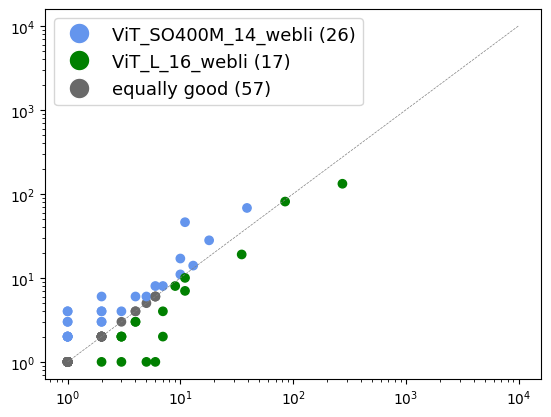

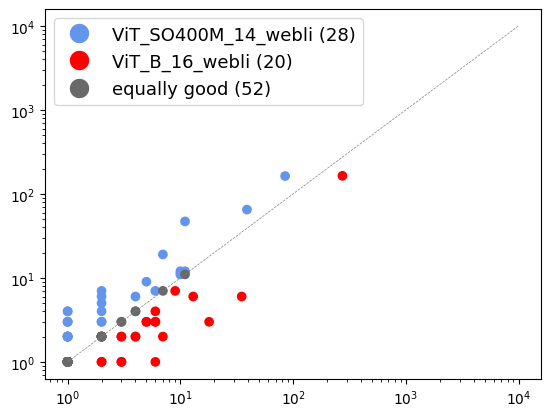

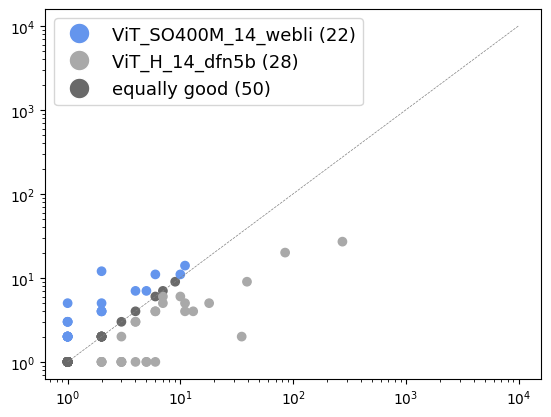

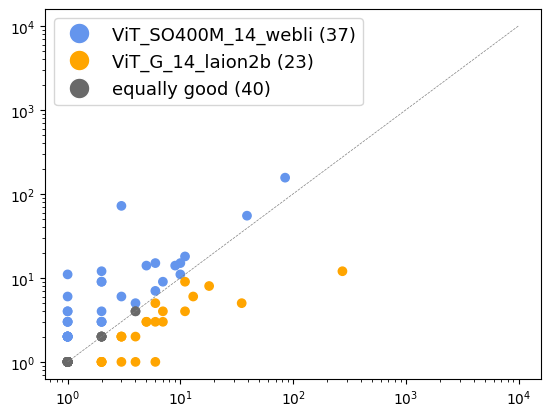

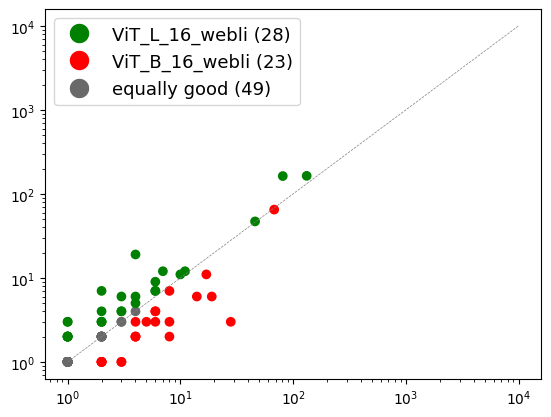

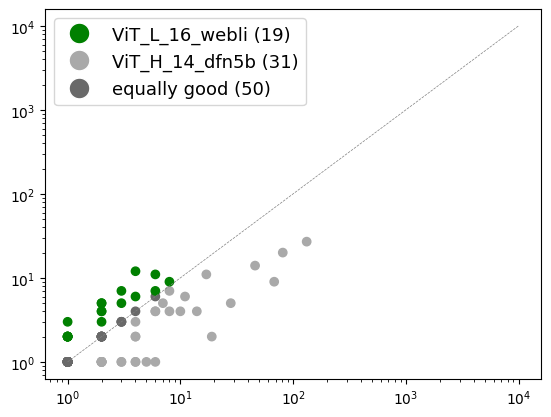

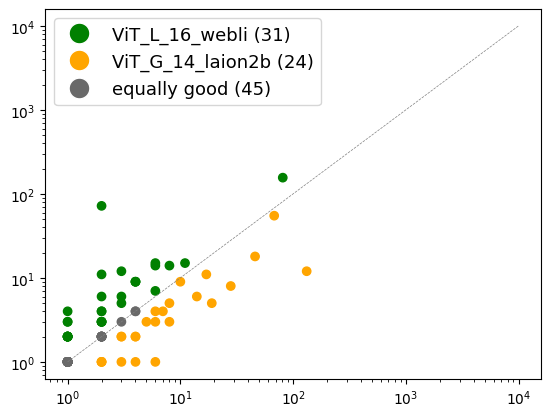

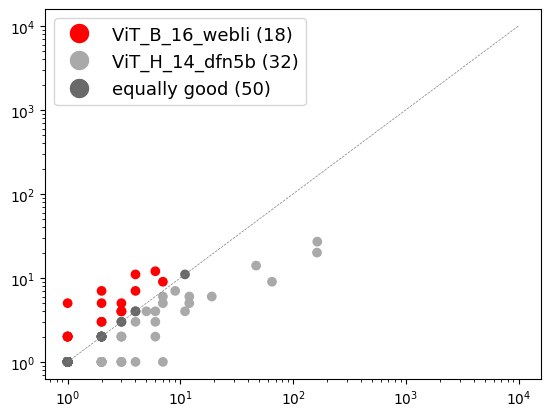

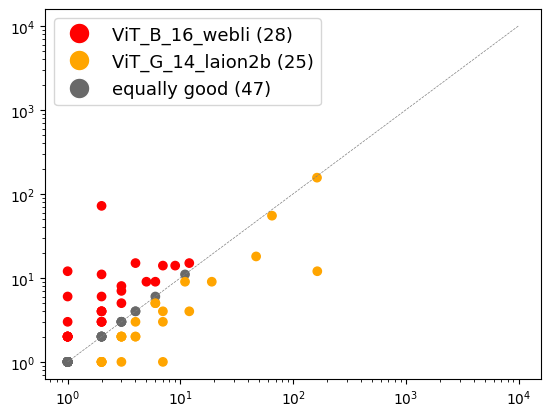

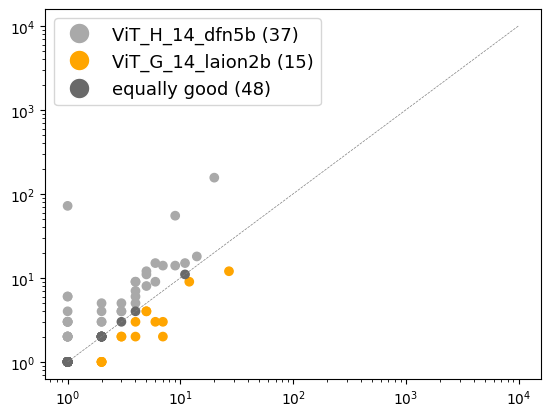

In [13]:
df_labels = pd.read_csv(os.path.join(project_root,f'datasets/{DATASET}/labels/labels.csv'))
labels_list = sorted(df_labels[f'{LABELS_TYPE}_label'].to_list())
models = ['openclip-ViT_SO400M_14_webli','openclip-ViT_L_16_webli','openclip-ViT_B_16_webli','openclip-ViT_H_14_dfn5b','openclip-ViT_G_14_laion2b' ]

path = "saves/ranks/"
# Create d input in form of dictionary
d = {m.split("-")[-1]:[b for a,b in load_from_file(os.path.join(project_root,path+f"{m}-{DATASET}-{LABELS_TYPE}.pkl"))] 
        for m in models}

colors_d = {"clip":"lightseagreen", 
            "blip2":"purple",
            "align":"gold",
            "ViT_SO400M_14_webli":"cornflowerblue",
            "ViT_L_16_webli":"green",
            "ViT_B_16_webli":"red",
            "ViT_H_14_dfn5b":"darkgrey",
            "ViT_G_14_laion2b":"orange",
            "ViT_H_14_laion2b":"orchid"}

    
plot_ranks2D(d,colors_d,labels_list, out_dir=None)

### Complementary Cumulative Graphs

First cell contains the help functions.

In [14]:
from itertools import combinations
    
def compute_cumulation(ranks, max_size = 9566):
    ranks_cumulation = [0] * max_size
    for rank in ranks:
        ranks_cumulation[rank:] = [x+1 for x in ranks_cumulation[rank:]]
    return ranks_cumulation
    
def plot_cumulative_complementary_graphs(models_results: dict, models_colors: dict , out_dir=None, n=500):
    # We want to save this plots in grid under diagonal so thats why reversed()
    names = reversed(models_results.keys())
    out_file_path = None
    for name1, name2 in list(combinations(names, 2)):
        if out_dir is not None:
            out_file_path = out_dir + name1 + "-" + name2 + ".png"
            plot_single_complementary_graph(models_results[name1], models_results[name2],
                                            name1, name2, models_colors[name1], models_colors[name2], n, out_file_path )
        else:
            plot_single_complementary_graph(models_results[name1], models_results[name2],
                                            name1, name2, models_colors[name1], models_colors[name2], n, None )
       

def plot_single_complementary_graph(ranks_1, ranks_2, name_1, name_2, color_1, color_2, n=500, out_file_path=None):
    complementary_ranks = [min(r1,r2) for r1, r2 in zip(ranks_1, ranks_2)]
    cumulations = [compute_cumulation(ranks_1), compute_cumulation(ranks_2), compute_cumulation(complementary_ranks)]
    plot_cumulative_graph(cumulations, n , [name_1, name_2, "Complement"], None, colors=[color_1, color_2, "dimgrey"],out_path=out_file_path, line_width=2.5)


For all combination of models specified in 'models' compute complementary cumulation graphs. The cumulation graphs are for DATASET and LABELS_TYPE. Note that to run this code we need coputed ranks for all models.

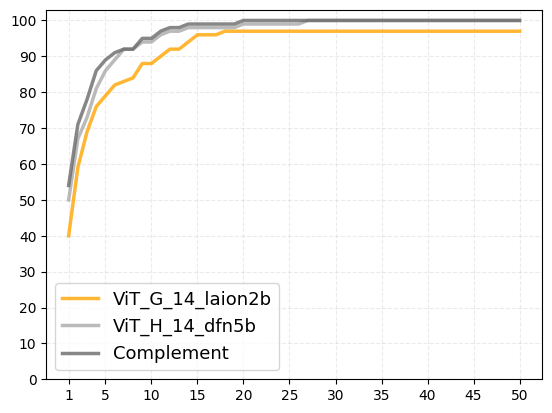

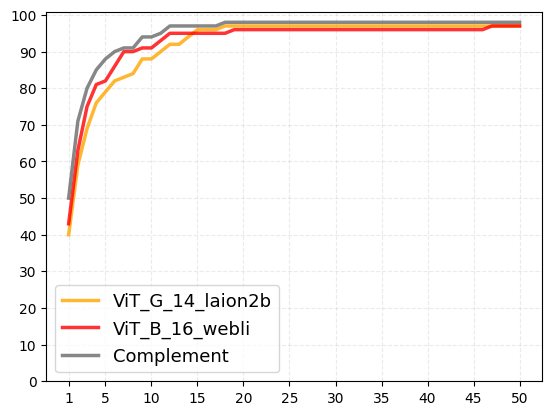

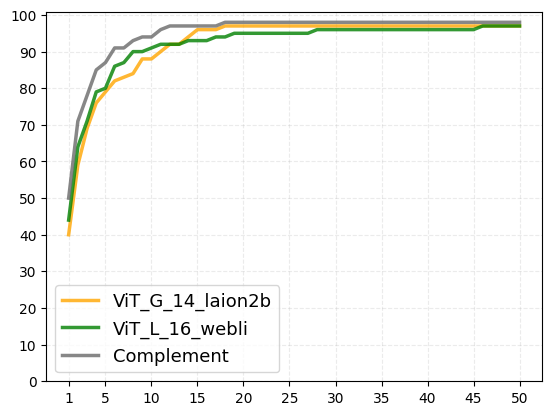

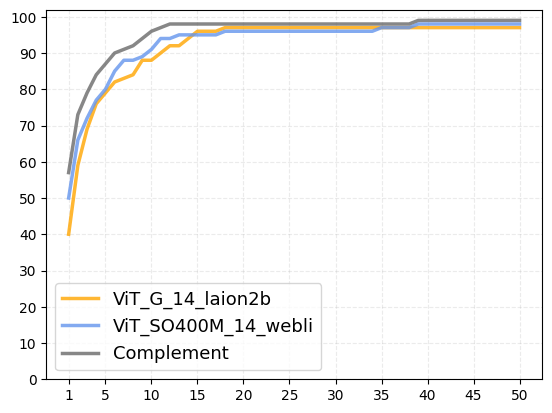

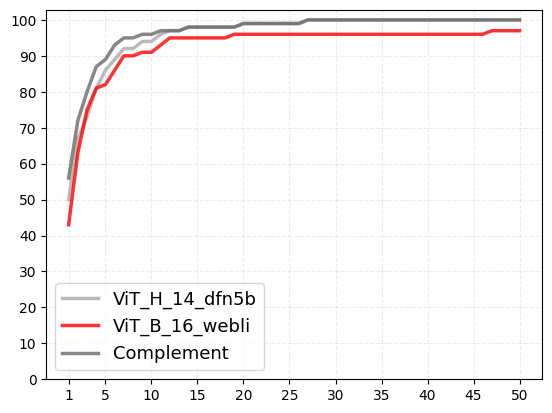

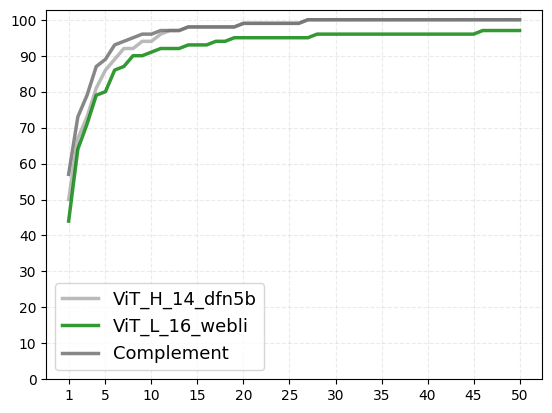

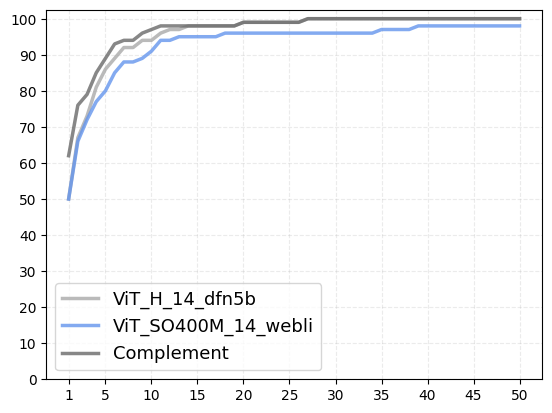

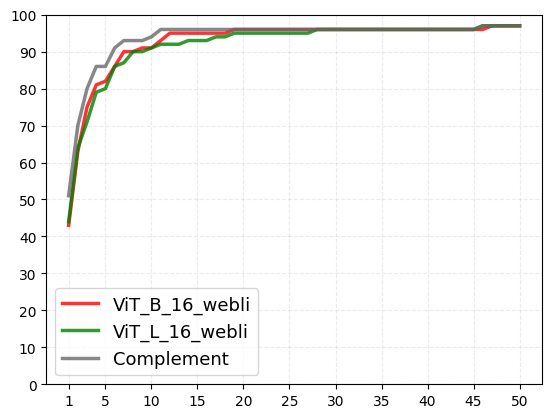

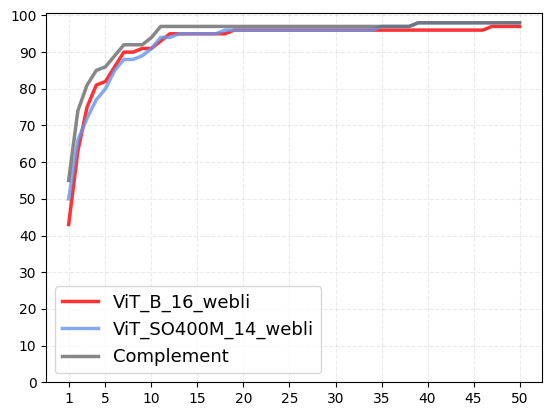

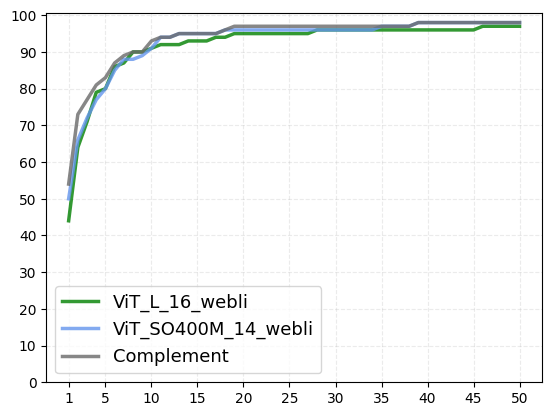

In [15]:
path = "saves/ranks/"
models = ['openclip-ViT_SO400M_14_webli','openclip-ViT_L_16_webli','openclip-ViT_B_16_webli','openclip-ViT_H_14_dfn5b','openclip-ViT_G_14_laion2b' ]
# Create d input in form of dictionary
d = {m.split("-")[-1]:[b for a,b in load_from_file(os.path.join(project_root, path+f"{m}-{DATASET}-{LABELS_TYPE}.pkl"))] 
        for m in models}

colors_d = {"clip":"lightseagreen", 
            "blip2":"purple",
            "align":"gold",
            "ViT_SO400M_14_webli":"cornflowerblue",
            "ViT_L_16_webli":"green",
            "ViT_B_16_webli":"red",
            "ViT_H_14_dfn5b":"darkgrey",
            "ViT_G_14_laion2b":"orange",
            "ViT_H_14_laion2b":"orchid"}

    
plot_cumulative_complementary_graphs(d,colors_d, out_dir=None, n= 50 if DATASET == "photos" else 500)
